In [3]:
pip install kaggle


d973f354c9d32e145c828aed00a6b1c4  haoranfei123


In [4]:
import os
os.environ['KAGGLE_USERNAME'] = 'haoranfei123'
os.environ['KAGGLE_KEY'] = 'd973f354c9d32e145c828aed00a6b1c4'

In [5]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 458MB/s]


In [6]:
import zipfile


with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall()

import pandas as pd


df_train = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

df_sub = pd.read_csv('sample_submission.csv')


print("Train head:")
print(df_train.head())
print("\nTest head:")
print(df_test.head())
print("\nSample Submission head:")
print(df_sub.head())


Train head:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008 

In [7]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score



# =========================
# 1️⃣ Data Preprocessing
# =========================

# Handle missing values: -> median to make sure valid of every data sample
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('SalePrice')  # exclude target
for col in num_cols:
    median = df_train[col].median()
    df_train[col] = df_train[col].fillna(median)
    df_test[col] = df_test[col].fillna(median)

# Encode categorical variables
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
df_train_encoded = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)

# Align test set columns with train set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns.drop('SalePrice'), fill_value=0)

# Separate features and target
X = df_train_encoded.drop('SalePrice', axis=1)
y = np.log1p(df_train_encoded['SalePrice'])  # log transform

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(df_test_encoded)

# Train-test split for internal evaluation (70% / 30%)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# =========================
# 2️⃣ Model Training and Evaluation
# =========================

# Linear Regression with k-fold CV
lin_reg = LinearRegression()
lin_cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-lin_cv_scores)
print("Linear Regression CV RMSE:", lin_rmse_scores)


lin_reg.fit(X_train, y_train)
y_val_pred_lin = lin_reg.predict(X_val)
print("Linear Regression Validation R2:", r2_score(y_val, y_val_pred_lin))

# Ridge Regression with multiple alphas and k-fold CV
alphas = [0.1, 0.3, 1, 3, 10, 30, 100]
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
print("Best alpha for Ridge:", ridge_cv.alpha_)

ridge_cv_scores = cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_rmse_scores = np.sqrt(-ridge_cv_scores)
print("Ridge CV RMSE scores:", ridge_rmse_scores)


y_val_pred_ridge = ridge_cv.predict(X_val)
print("Ridge Validation R2:", r2_score(y_val, y_val_pred_ridge))

# =========================
# 3️⃣ Model Comparison
# =========================
print("\nModel Comparison on Validation Set:")
print(f"Linear Regression R2: {r2_score(y_val, y_val_pred_lin):.3f}")
print(f"Ridge Regression R2: {r2_score(y_val, y_val_pred_ridge):.3f}")
print("Linear Regression CV RMSE mean:", lin_rmse_scores.mean())
print("Ridge CV RMSE mean:", ridge_rmse_scores.mean())

# =========================
# 4️⃣ Ridge Alpha Experiments & Kaggle Submission
# =========================
for alpha in [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]:
    ridge = RidgeCV(alphas=[alpha], scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
    print(f"Ridge alpha={alpha}, Validation RMSE: {rmse:.2f}")

# Final prediction on test set using best Ridge alpha
y_test_pred_log = ridge_cv.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

# Prepare submission
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': y_test_pred
})
submission.to_csv('submission_ridge.csv', index=False)
print("Submission file saved!")


Linear Regression CV RMSE: [0.12892002 0.28797436 0.16607483 0.11685145 0.21874038]
Linear Regression Validation R2: 0.7832441336404377
Best alpha for Ridge: 100.0
Ridge CV RMSE scores: [0.12418077 0.25096448 0.1566775  0.11952967 0.17385427]
Ridge Validation R2: 0.8794372046130793

Model Comparison on Validation Set:
Linear Regression R2: 0.783
Ridge Regression R2: 0.879
Linear Regression CV RMSE mean: 0.18371220951259662
Ridge CV RMSE mean: 0.16504133909005891
Ridge alpha=0.1, Validation RMSE: 24571.93
Ridge alpha=0.3, Validation RMSE: 24543.46
Ridge alpha=1, Validation RMSE: 24497.65
Ridge alpha=3, Validation RMSE: 24493.80
Ridge alpha=10, Validation RMSE: 24461.38
Ridge alpha=30, Validation RMSE: 24302.98
Ridge alpha=100, Validation RMSE: 24308.34
Ridge alpha=300, Validation RMSE: 25328.87
Ridge alpha=1000, Validation RMSE: 29723.90
Submission file saved!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


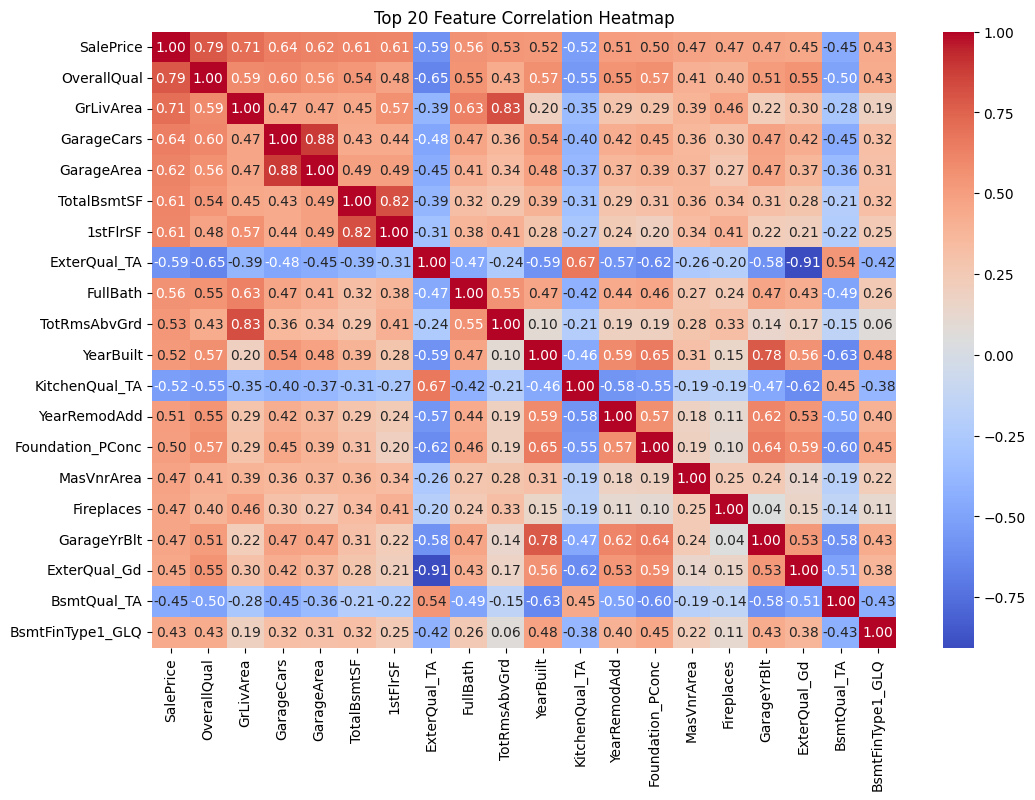

/tmp/ipython-input-2333216776.py:48: RuntimeWarning: overflow encountered in expm1
  y_train_pred_exp = np.expm1(np.clip(y_train_pred, 0, 1e6))


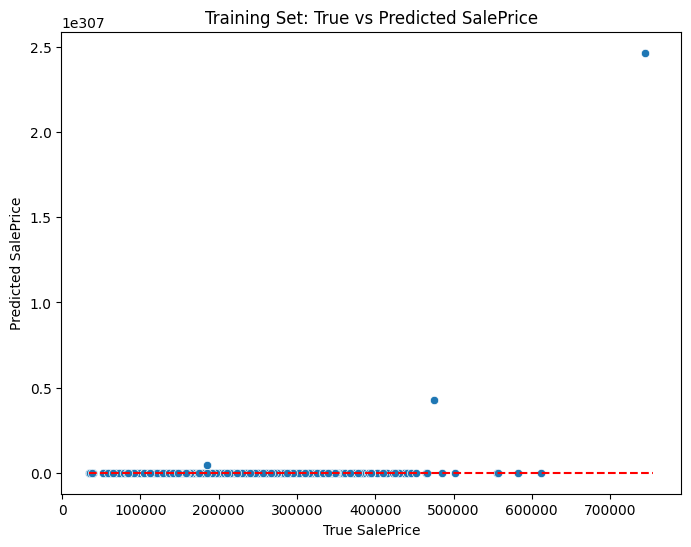

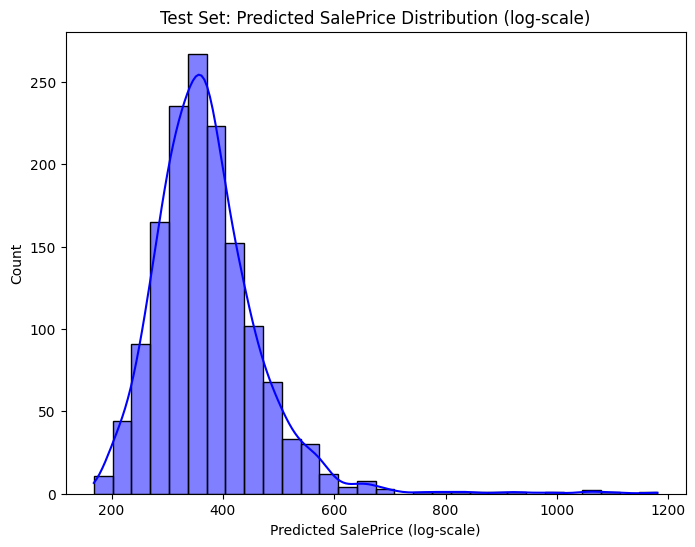

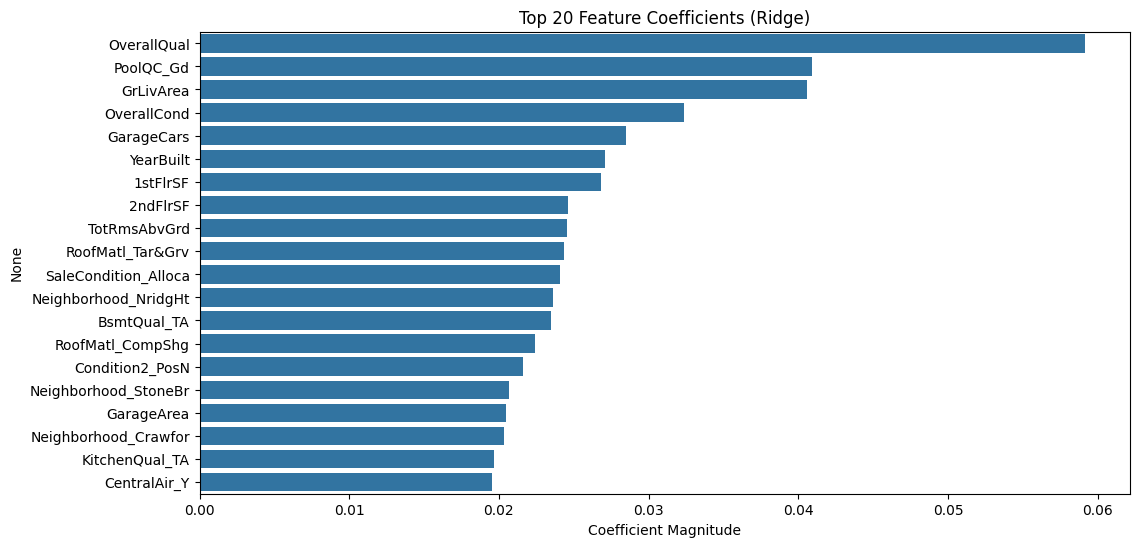

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =========================
# 0️⃣ Prepare Data
# =========================
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns.drop('SalePrice'), fill_value=0)

# Fill missing numerical values with median
num_cols = df_train_encoded.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('SalePrice')
for col in num_cols:
    median = df_train_encoded[col].median()
    df_train_encoded[col] = df_train_encoded[col].fillna(median)
    df_test_encoded[col] = df_test_encoded[col].fillna(median)

X_train = df_train_encoded.drop('SalePrice', axis=1)
y_train = np.log1p(df_train_encoded['SalePrice'])  # log-transform target
X_test = df_test_encoded

# Ensure ridge_cv is already trained on log1p(SalePrice)
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# =========================
# 1️⃣ Correlation Heatmap (Top 20 Features)
# =========================
corr_matrix = df_train_encoded.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(20).index

plt.figure(figsize=(12,8))
sns.heatmap(df_train_encoded[top_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 20 Feature Correlation Heatmap")
plt.show()

# =========================
# 2️⃣ Training Set: True vs Predicted SalePrice
# =========================
# Safe conversion from log1p to original scale, clip to avoid overflow
y_train_exp = np.expm1(np.clip(y_train, 0, 1e6))
y_train_pred_exp = np.expm1(np.clip(y_train_pred, 0, 1e6))

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train_exp, y=y_train_pred_exp)
plt.plot([y_train_exp.min(), y_train_exp.max()],
         [y_train_exp.min(), y_train_exp.max()],
         color='red', linestyle='--')
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Training Set: True vs Predicted SalePrice")
plt.show()

# -----------------------------
# 3️⃣ Training Set: Residual Distribution (log-scale, safe)
# -----------------------------
# Compute residuals in log scale
# Predicted distribution (log scale, safe)
y_test_pred_log = y_test_pred
y_test_pred_log = y_test_pred_log[np.isfinite(y_test_pred_log)]

plt.figure(figsize=(8,6))
sns.histplot(y_test_pred_log, kde=True, bins=30, color='blue')
plt.xlabel("Predicted SalePrice (log-scale)")
plt.title("Test Set: Predicted SalePrice Distribution (log-scale)")
plt.show()




# =========================
# Ridge Feature Coefficients (Top 20)
# =========================
ridge_coeffs = pd.Series(ridge_cv.coef_, index=X_train.columns)
top_coeffs = ridge_coeffs.abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_coeffs.values, y=top_coeffs.index)
plt.title("Top 20 Feature Coefficients (Ridge)")
plt.xlabel("Coefficient Magnitude")
plt.show()
